# Introduzione

Quello che andiamo a fare in questa esercitazione è il calcolo del funzione d'onda di ground-state per un sistema quantistico monodimensionale soggetto al potenziale:
$$
V(x) = x^4 - \frac{5}{2}x^2.
$$
Poichè $\langle {\hat H} \rangle_T \geq E_0 $, la funzione d'onda di ground-state la possiamo ricercare fra quelle che minimizzano il $\langle {\hat H} \rangle_T$. Per calcolare il $\langle {\hat H} \rangle_T$ adottiamo due diversi algoritmi, ossia l'algoritmo di Metropolis ed il Path-Integral.

* L'**algoritmo di Metropolis**, come ben sappiamo, approssima l'integrale esprimendolo come il valor medio di una certa distribuzione. In questo caso specifico, abbiamo che:
$$\begin{aligned}
\langle {\hat H} \rangle_T & = \int dx \, \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}\\ 
&= \int dx \, \underbrace{\frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}}_{p(x)} \underbrace{\frac{\left[V(x)-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\right] \Psi_T(x)}{\Psi_T(x)}}_{f(x)}\\
& \approx \frac{1}{N} \sum_{i=1}^N f(x_i)
\end{aligned}$$
dove il sampling della distribuzione $p(x)$ viene fatto attraverso una probabilità di transizione uniforme, $T(x_{i}|x_{i-1}) = 1$. Chiaramente per procedere alla minimizzazione dobbiamo scegliere una funzione d'onda di test. La scelta che facciamo è $\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$ poichè ricalca la forma della funzione d'onda teorica. I parametri da ottimizzare sono chiaramente $\sigma$ e $\mu$. 

* Il **Path-Integral** è invece una procedura in cui la funzione d'onda di ground-state viene aprrossimata attraverso un'evoluzione temporale in campo complesso di una funzione d'onda di test $\Psi_T$. Per capire come questo sia possibile, riscriviamo il valor medio di $\hat H$ in termini della matrice densità:
$$
\langle {\hat H} \rangle_T = \int dr dr' \rho(r,r',\beta) \langle r | \hat H | r' \rangle
$$
    Dopodichè sfruttiamo l'approssimazione primitiva e la formula di Trotter per esprimere la matrice densità come integrale sul cammino: 
$$
\rho(r_0,r_M,\beta) =  \int dr_1 ... \int dr_{M-1} \rho (r_0,r_1,\beta) \cdot ... \cdot \rho(r_{M-1},r_M,\beta) \\
$$
    dove: 
$$
\begin{aligned}
\rho(r_n,r_{n+1},\beta) & \approx \int dr' \langle r_n | e^{-\frac{\tau}{M} \hat T }| r' \rangle \langle r'| e^{-\frac{\tau}{M} \hat V }| r_{n+1} \rangle \\
& = e^{-\frac{\tau}{M}  V(r_{n+1}) }\delta(r_{n+1}-r_n)\cdot  \frac{1}{(4\pi \lambda \tau)^{-3N/2}} \exp\left[ -\frac{(r_{n+1}-r_{n})^2}{4\lambda \tau}\right]
\end{aligned}
$$
    Questo risultato ci permette quindi di ricavare la funzione d'onda del ground-state come evoluzione della funzione di test. Osserviamo che in questo caso l'energia cinetica si comporta come un'accoppiamento elastico fra i diversi step. Uno dei vantaggi associati all'utilizzo del path-integral è il fatto che semplifica notevolmente l'elaborazione numerica. Infatti non è necessario eseguire un sampling della parte cinetica poiché possiamo direttamente estrarre valori dalla distribuzione esatta. Inoltre, un altro vantaggio di questa procedura è che non è necessario scegliere come funzione d'onda iniziale una funzione d'onda che approssimi quella reale. 

Procediamo ora a studiare il sistema attraverso l'algoritmo di Metropolis, per poi confrontare la funzione d'onda così ricavata con quella associata all path integral.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import subprocess as sb
from os import system
import os
import shutil

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

In [2]:
path1 = os.path.abspath(os.getcwd())
path = os.path.abspath(os.getcwd())+'/Exercises_8.01/'

# Metropolis

Eseguiamo una stima dell'energia di ground state con la funzione di test $\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$ con due parametri generici per veficare la correttezza dell'algoritmo.
$$\mu = 0.7 \quad  \quad \sigma = 0.6$$

In [3]:
# 0. nstep; 1. nblock; 2. mu; 3. sigma; 4. delta_x; 5. x_0
mu = 0.7
sigma = 0.6

 # Cambio il numero di step
a_file = open(path+"input.dat", "r")
list_of_lines = a_file.readlines()
list_of_lines[0] = "1000\n"
list_of_lines[1] = "300\n"
list_of_lines[2] = str(mu)+"\n"
list_of_lines[3] = str(sigma)+"\n"
list_of_lines[4] = "2\n"
list_of_lines[5] = "0\n"
a_file = open(path+"input.dat", "w")
a_file.writelines(list_of_lines)
a_file.close()

 # Compilo il programma con il nuovo file di input
os.chdir(path)
sb.call('./clean.sh', shell=True)
os.system('./Monte_Carlo_NVT.exe %f %f')

block, integral, integral_std = np.loadtxt("file_mean_integral.txt",delimiter = ",", unpack = True)
x, bins, bins_std = np.loadtxt("output.histo.0", unpack = True)

In [4]:
def wave_function_sq(x, mu, sigma):
    a = np.exp( - (x-mu)**2./(2.*sigma**2.) ) + np.exp( - (x+mu)**2./(2.*sigma**2.) ) 
    b = np.sqrt(2. * np.sqrt(np.pi) *sigma *(1. + np.exp( - (mu/sigma)**2.)))
    return  a/b

bins_exact = np.zeros(len(bins))
for i in range(len(bins)):
    bins_exact[i] = wave_function_sq(x[i], mu, sigma) * wave_function_sq(x[i], mu, sigma)

In [5]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x_th = np.linspace(-a/2, a/2, N)
dx = x_th[1] - x_th[0] # the step size
V = Vpot(x_th)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

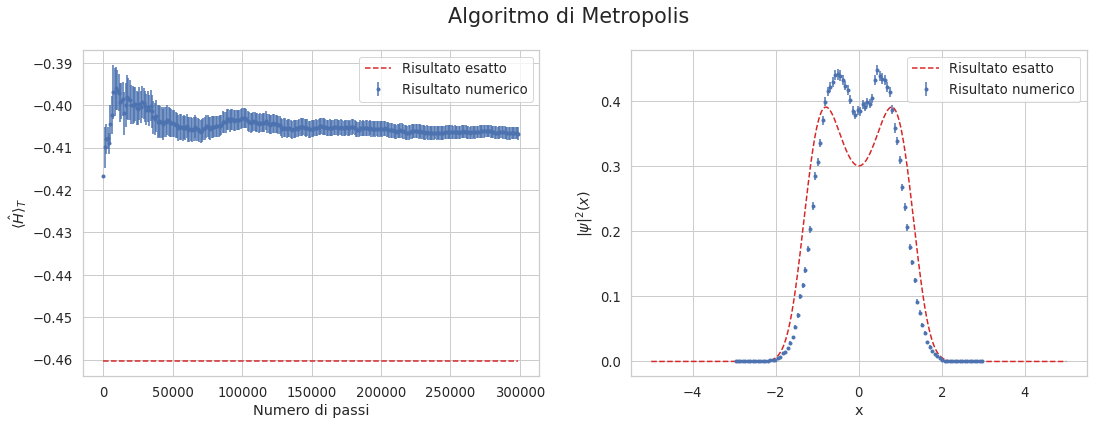

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,6)); 
fig.suptitle(r'Algoritmo di Metropolis', fontsize='x-large')
ax = ax.ravel()

ax[0].errorbar(
    block,
    integral,
    yerr = integral_std,  
    marker='.', linestyle="", label='Risultato numerico'
);

ax[0].hlines(-0.46046587969271563, 0, max(block), color=plt.cm.tab10(3),linestyle='--', label='Risultato esatto');
ax[0].grid(':')
ax[0].set_xlabel('Numero di passi')
ax[0].set_ylabel(r'$\langle {\hat H} \rangle_T  $');
ax[0].legend();

ax[1].errorbar(
    x,
    bins,
    yerr = bins_std,  
    marker='.', linestyle="", label='Risultato numerico'
);


ax[1].plot(x_th,(psi[0])**2, label='Risultato esatto', color=plt.cm.tab10(3),linestyle='--', )

ax[1].grid(':')
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'$|\psi|^2(x) $');
ax[1].legend();

Osserviamo che il risultato ottenuto non è particolarmente soddisfacente. Tuttavia ora eseguiamo un'analisi un'analisi variazionale alla ricerca dei migliori parametri $\mu$ e $\rho$ attraverso un campionamento uniforme nell'intervallo $\mu,\sigma \in [0.5,0.9]$.

In [7]:
N_value = 20
mu = np.linspace(0.5,0.9,N_value)
sigma = np.linspace(0.5,0.9,N_value)
E = np.zeros((N_value,N_value))

for i in range(N_value):
    
    print("PROGRESS:   ", i, " su ", N_value)
            
    for j in range(N_value):

        # Inserisco i nuovi parametri d'inizio
        a_file = open("input.dat", "r")
        list_of_lines = a_file.readlines()
        list_of_lines[2] = str(mu[i])+"\n"
        list_of_lines[3] = str(sigma[j])+"\n"
        a_file = open("input.dat", "w")
        a_file.writelines(list_of_lines)
        a_file.close()

        # Compilo il programma con il nuovo file di input
        sb.call('./clean.sh', shell=True)
        os.system('./Monte_Carlo_NVT.exe %f %f')

        # Leggo i dati
        block, integral, integral_std = np.loadtxt("file_mean_integral.txt",delimiter = ",", unpack = True)
        E[i,j] = integral[len(block)-1]
    

PROGRESS:    0  su  20
PROGRESS:    1  su  20
PROGRESS:    2  su  20
PROGRESS:    3  su  20
PROGRESS:    4  su  20
PROGRESS:    5  su  20
PROGRESS:    6  su  20
PROGRESS:    7  su  20
PROGRESS:    8  su  20
PROGRESS:    9  su  20
PROGRESS:    10  su  20
PROGRESS:    11  su  20
PROGRESS:    12  su  20
PROGRESS:    13  su  20
PROGRESS:    14  su  20
PROGRESS:    15  su  20
PROGRESS:    16  su  20
PROGRESS:    17  su  20
PROGRESS:    18  su  20
PROGRESS:    19  su  20


In [8]:
length = 4

for i in range(len(mu)):
    if (i==0):
        df = pd.DataFrame({r'$\mu$':np.round(mu[i],length), r'$\sigma$': np.round(sigma,length), 'ene':np.round(E[i,:],length)      
                          })
    else: 
        df_1 = pd.DataFrame({r'$\mu$':np.round(mu[i],length), r'$\sigma$': np.round(sigma,length), 'ene':np.round(E[i,:],length)      
                          })
        df =pd.concat([df, df_1], ignore_index = True, axis = 0)
        
min_pos = df.loc[df['ene']==np.round(np.min(E),length)].to_numpy()

df = df.pivot(r'$\mu$', r'$\sigma$', "ene")

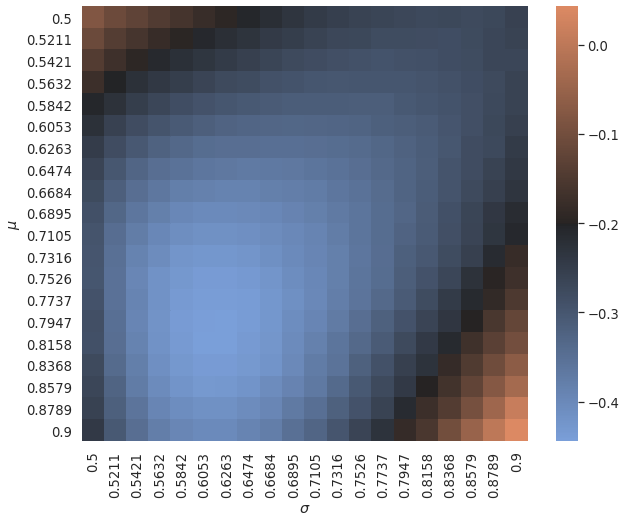

In [9]:
fig, plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(250, 30, l=65, center="dark",  s=60, as_cmap=True)
ax = sns.heatmap(df,cmap=cmap)

Rieseguiamo ora il codice con i parametri ottimali e vediamo se si riscontrano differenze apprezzabili.

In [10]:
# 0. nstep; 1. nblock; 2. mu; 3. sigma; 4. delta_x; 5. x_0
mu = min_pos[0,0]
sigma = min_pos[0,1]

 # Cambio il numero di step
a_file = open(path+"input.dat", "r")
list_of_lines = a_file.readlines()
list_of_lines[0] = "1000\n"
list_of_lines[1] = "300\n"
list_of_lines[2] = str(mu)+"\n"
list_of_lines[3] = str(sigma)+"\n"
list_of_lines[4] = "2\n"
list_of_lines[5] = "0\n"
a_file = open(path+"input.dat", "w")
a_file.writelines(list_of_lines)
a_file.close()

 # Compilo il programma con il nuovo file di input
os.chdir(path)
sb.call('./clean.sh', shell=True)
os.system('./Monte_Carlo_NVT.exe %f %f')

block, integral, integral_std = np.loadtxt("file_mean_integral.txt",delimiter = ",", unpack = True)
x, bins, bins_std = np.loadtxt("output.histo.0", unpack = True)

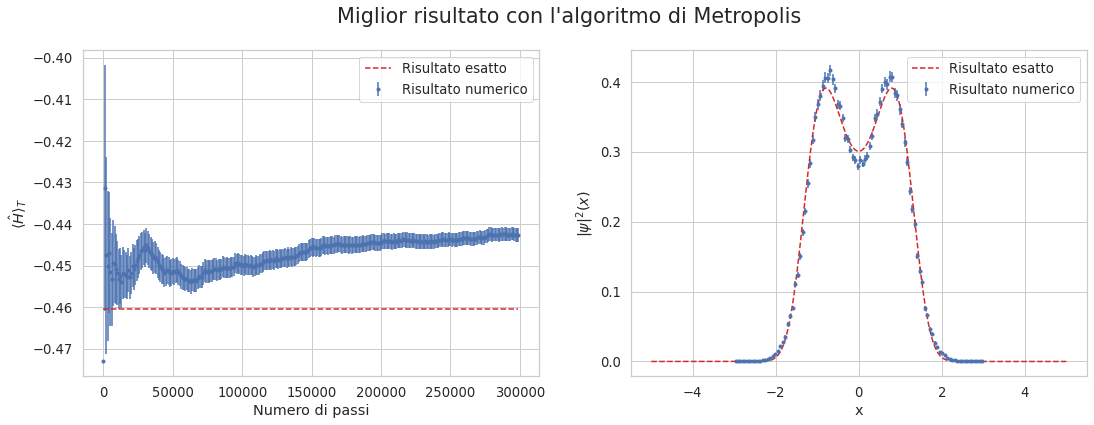

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18,6)); 
fig.suptitle(r"Miglior risultato con l'algoritmo di Metropolis", fontsize='x-large')
ax = ax.ravel()

ax[0].errorbar(
    block,
    integral,
    yerr = integral_std,  
    marker='.', linestyle="", label='Risultato numerico'
);

ax[0].hlines(-0.46046587969271563, 0, max(block), color=plt.cm.tab10(3),linestyle='--', label='Risultato esatto');
ax[0].grid(':')
ax[0].set_xlabel('Numero di passi')
ax[0].set_ylabel(r'$\langle {\hat H} \rangle_T  $');
ax[0].legend();

ax[1].errorbar(
    x,
    bins,
    yerr = bins_std,  
    marker='.', linestyle="", label='Risultato numerico'
);


ax[1].plot(x_th,(psi[0])**2, label='Risultato esatto', color=plt.cm.tab10(3),linestyle='--', )

ax[1].grid(':')
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'$|\psi|^2(x) $');
ax[1].legend();

> Vediamo che il risultato ottenuto in questo caso è piuttosto soddisfaciente. Abbiamo infatti un buon accordo fra valore esatto e valore numerico sia per l'energia media che per la forma della funzione d'onda.

# Path Integral

Studiamo ora la funzione d'onda del ground-state ottenuta attraverso questa procedura e la confrontiamo con quella del Metropolis. In particolare confrontiamo come si comporta l'algoritmo quando utilizziamo una $\Psi_T=1$ oppure $\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$. In entrambi i casi eseguiamo una simulazione a $T=0$.

In [12]:
path = path1+'/Exercises_8.03/'
os.chdir(path)

In [13]:
# 17. psi_type; 18. mu; 19. sigma

 # Cambio il numero di step
shutil.copyfile(path+'input.pigs', path+'input.dat')
a_file = open(path+"input.dat", "r")
list_of_lines = a_file.readlines()
list_of_lines[17] = 'psi_tipe				0\n'
a_file = open(path+"input.dat", "w")
a_file.writelines(list_of_lines)
a_file.close()

 # Compilo il programma con il nuovo file di input
os.system(' ./qmc1d')

x_PATH, psi_PATH_0, psi_PATH_std_0 = np.loadtxt("probability.dat", unpack = True)

In [14]:
# 17. psi_type; 18. mu; 19. sigma

 # Cambio il numero di step
shutil.copyfile(path+'input.pigs', path+'input.dat')
a_file = open(path+"input.dat", "r")
list_of_lines = a_file.readlines()
list_of_lines[17] = 'psi_tipe				1\n'
list_of_lines[18] = 'mu				' +str(min_pos[0,0])+'\n'
list_of_lines[19] = 'sigma				'+str(min_pos[0,1])+'\n'
a_file = open(path+"input.dat", "w")
a_file.writelines(list_of_lines)
a_file.close()

 # Compilo il programma con il nuovo file di input
os.system(' ./qmc1d')

x_PATH, psi_PATH_1, psi_PATH_std_1 = np.loadtxt("probability.dat", unpack = True)

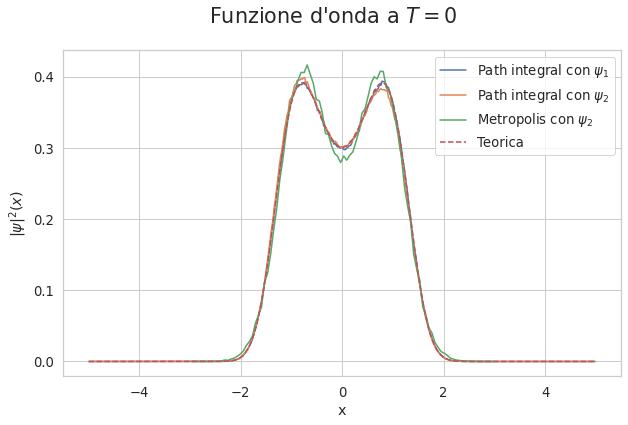

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,6)); 

fig.suptitle(r"Funzione d'onda a $T=0$", fontsize='x-large')

ax.plot(
    x_PATH,
    psi_PATH_0,
    #yerr = psi_PATH_std_0,  
    marker='', linestyle="-", label=r'Path integral con $\psi_1$'
);

ax.plot(
    x_PATH,
    psi_PATH_1,
    #yerr = psi_PATH_std_1,  
    marker='', linestyle="-", label=r'Path integral con $\psi_2$'
);


ax.plot(
    x,
    bins,
    #yerr = bins_std,  
    marker='', linestyle="-", label='Metropolis con $\psi_2$'
);

plt.plot(x_th,(psi[0])**2,linestyle='--', label='Teorica')

ax.grid(':')
ax.set_xlabel('x')
ax.set_ylabel(r'$|\psi|^2(x)  $');
ax.legend();

> Vediamo che questa procedura è notevolmente più precisa. Come abbiamo già osservato nell'introduzione, questo è dovuto al fatto che per la parte cinetica possiamo estrarre valori dalla distribuzione esatta senza eseguire un sampling.

### Cosa cambia a $T\neq 0$?

Studiamo ora come cambi la $\Psi_T$ quando simuliamo il istema a $T\neq 0 $. 

In [16]:
# 17. psi_type; 18. mu; 19. sigma
T =[0,1,2,4,6,8]
psi_temp = np.zeros((len(T),len(psi_PATH_1)))
psi_temp_std = np.zeros((len(T),len(psi_PATH_1)))
x_temp = np.zeros((len(T),len(psi_PATH_1)))

for i in range(len(T)):
     # Cambio il numero di step
    shutil.copyfile(path+'input.pigs', path+'input.dat')
    a_file = open(path+"input.dat", "r")
    list_of_lines = a_file.readlines()
    list_of_lines[1] = 'temperature				'+str(T[i])+'\n'
    list_of_lines[17] = 'psi_type				1\n'
    list_of_lines[18] = 'mu				' +str(min_pos[0,0])+'\n'
    list_of_lines[19] = 'sigma				'+str(min_pos[0,1])+'\n'
    a_file = open(path+"input.dat", "w")
    a_file.writelines(list_of_lines)
    a_file.close()

     # Compilo il programma con il nuovo file di input
    os.system(' ./qmc1d')

    x_temp[i], psi_temp[i], psi_temp_std[i] = np.loadtxt("probability.dat", unpack = True)

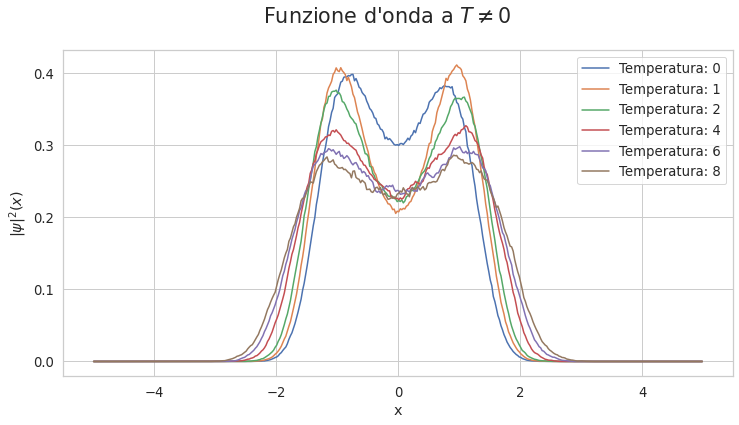

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12,6)); 

fig.suptitle(r"Funzione d'onda a $T\neq 0$", fontsize='x-large')


for i in range(len(T)):
    ax.plot(
        x_temp[i],
        psi_temp[i],
        #yerr = psi_temp_std[i],  
        marker='', linestyle="-", label=r'Temperatura: '+str(T[i])
    );

ax.legend();
ax.grid(':')
ax.set_xlabel('x')
ax.set_ylabel(r'$|\psi|^2(x)  $');
ax.legend();

> Osserviamo che quando $T\neq 0$ vengono popolati anche stati eccitati del sistema con un conseguente ampliamento spaziale della funzione d'onda.

### Posso ridurre i passi temporali?

Ci chiediamo ora se nel caso in cui consideriamo come funzione d'onda di test la $\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$, è possibile ridurre il numero di passi temporali necessari per la simulazione. 

In [18]:
time_slice =[300,250,200]
psi_time_slice = np.zeros((len(time_slice),len(psi_PATH_1)))
psi_time_slice_std = np.zeros((len(time_slice),len(psi_PATH_1)))
x_time_slice = np.zeros((len(time_slice),len(psi_PATH_1)))

for i in range(len(time_slice)):
     # Cambio il numero di step
    shutil.copyfile(path+'input.pigs', path+'input.dat')
    a_file = open(path+"input.dat", "r")
    list_of_lines = a_file.readlines()
    list_of_lines[0] = 'timeslices				'+str(time_slice[i])+'\n'
    list_of_lines[17] = 'psi_type				1\n'
    list_of_lines[18] = 'mu				' +str(min_pos[0,0])+'\n'
    list_of_lines[19] = 'sigma				'+str(min_pos[0,1])+'\n'
    a_file = open(path+"input.dat", "w")
    a_file.writelines(list_of_lines)
    a_file.close()

     # Compilo il programma con il nuovo file di input
    os.system(' ./qmc1d')

    x_time_slice[i], psi_time_slice[i], psi_time_slice_std[i] = np.loadtxt("probability.dat", unpack = True)

In [19]:
time_slice =[300,250,200]
psi_time_slice_unif = np.zeros((len(time_slice),len(psi_PATH_1)))
psi_time_slice_std_unif = np.zeros((len(time_slice),len(psi_PATH_1)))
x_time_slice_unif = np.zeros((len(time_slice),len(psi_PATH_1)))

for i in range(len(time_slice)):
     # Cambio il numero di step
    shutil.copyfile(path+'input.pigs', path+'input.dat')
    a_file = open(path+"input.dat", "r")
    list_of_lines = a_file.readlines()
    list_of_lines[0] = 'timeslices				'+str(time_slice[i])+'\n'
    list_of_lines[17] = 'psi_type				0\n'
    list_of_lines[18] = 'mu				' +str(min_pos[0,0])+'\n'
    list_of_lines[19] = 'sigma				'+str(min_pos[0,1])+'\n'
    a_file = open(path+"input.dat", "w")
    a_file.writelines(list_of_lines)
    a_file.close()

     # Compilo il programma con il nuovo file di input
    os.system(' ./qmc1d')

    x_time_slice_unif[i], psi_time_slice_unif[i], psi_time_slice_std_unif[i] = np.loadtxt("probability.dat", unpack = True)

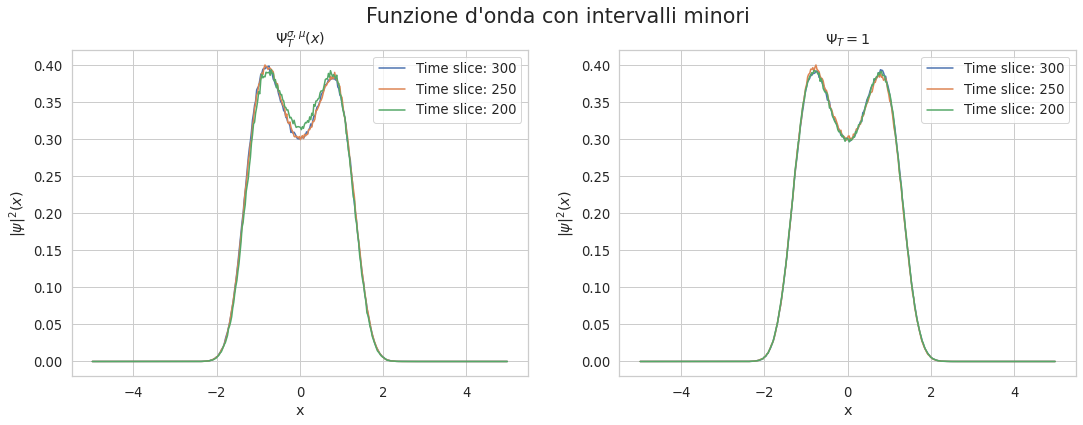

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,6)); 

fig.suptitle(r"Funzione d'onda con intervalli minori", fontsize='x-large')

ax = ax.ravel()

for i in range(len(time_slice)):
    ax[0].plot(
        x_time_slice[i],
        psi_time_slice[i],
        #yerr = psi_time_slice_std[i],  
        marker='', linestyle="-", label=r'Time slice: '+str(time_slice[i])
    );
    
    ax[1].plot(
        x_time_slice_unif[i],
        psi_time_slice_unif[i],
        #yerr = psi_time_slice_std[i],  
        marker='', linestyle="-", label=r'Time slice: '+str(time_slice[i])
    );

ax[0].legend()
ax[0].grid(':')
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'$|\psi|^2(x)  $');
ax[0].legend();
ax[0].set_title(r'$\Psi_T^{\sigma,\mu}(x)$')

ax[1].legend()
ax[1].grid(':')
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'$|\psi|^2(x)  $');
ax[1].legend()
ax[1].set_title('$\Psi_T=1$');

> Vediamo che, in contraddizione con quanto ci saremmo aspettati, utilizzando la funzione $\Psi_T^{\sigma,\mu}(x)$ si ha una riduzione maggiore della precisione rispetto a $\Psi_T=1$.